Eigentliche gute Vorhersage.
Jetzt mehr backcandles ausprobieren, hyperparamter anapassen. inputs wo 150 ist. möglichkeit weitere indikatoren oder wie auch immer.

PROBLEM: Warum das Modell einen Denkfehler hat: Das Modell lernt, dass der aktuelle closingprice nicht all zu weit vom nächsten closingpreis entfernt seien wird. Jeder vorhergesagte Wert der nah am Closingpreis des vorherigen Tages ist, sieht aus als sei er genau.
Es sieht gut aus aber man kann erkennen, dass vorhersage nur 1 Tag verzögerter tatsächlicher Wert ist.
Modell versucht Closing Preis des nächsten Tages vorherzusagen anhand vergangener Daten. Das wird für jeden Tag getestet und soll zukpünftige Werte vorherzusagen

Neuer Ansatz. Target ist der Unterschied zwischen Close der aktuellen Kerze zur nächsten Close Kerze. Es wird nun statt dem Closepreis des nächsten Tages vorherzusagen, versucht um wie viel der preis hoch oder runter geht. Wo ist der Unterschied? Nächster candle Price vs Preisbewegung.

In [1]:
# Importieren der Bibliotheken
import mlflow
import mlflow.keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import ta



In [2]:
# Setzen des MLflow Tracking URI und Anlegen eines neuen Experiments
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction LSTM v2")


<Experiment: artifact_location='file:///C:/WWI2021/Semester 6/Machine Learning Project/mlruns/2', creation_time=1717150141256, experiment_id='2', last_update_time=1717150141256, lifecycle_stage='active', name='Bitcoin Price Movement Prediction LSTM v2', tags={}>

In [3]:
#.\venv\Scripts\activate

In [4]:
data = pd.read_csv("C:\WWI2021\Semester 6\Machine Learning Project\LSTM_BTC\data\BTC-USD.csv")
#data

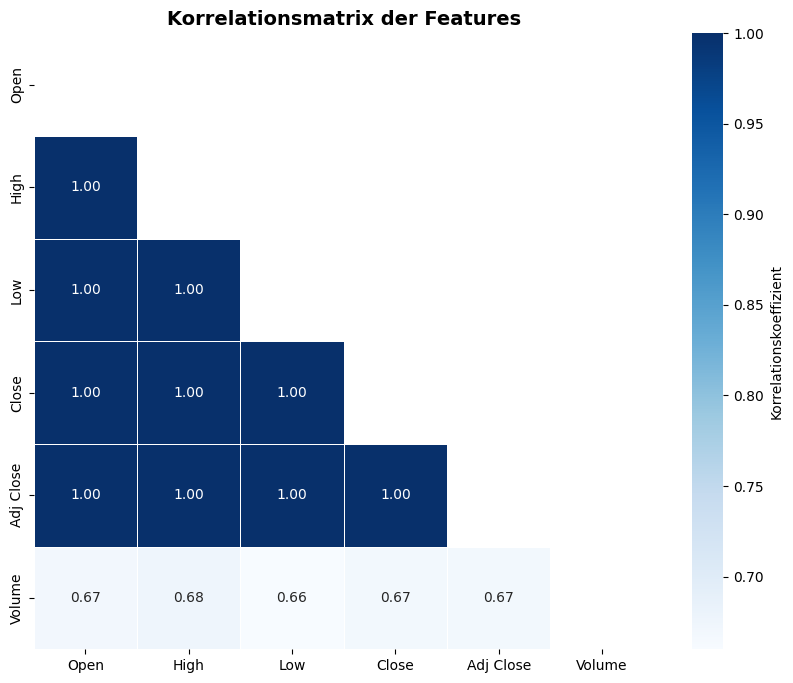

In [5]:
# Berechnen der Korrelationsmatrix
corr = data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask, cbar_kws={'label': 'Korrelationskoeffizient'},
            linewidths=0.5, linecolor='white')
plt.title('Korrelationsmatrix der Features', fontsize=14, fontweight='bold')
plt.show()

In [6]:
data['RSI'] = ta.momentum.RSIIndicator(data['Close']).rsi()
data['EMA20'] = ta.trend.EMAIndicator(data['Close'], window=20).ema_indicator()
data['EMA100'] = ta.trend.EMAIndicator(data['Close'], window=100).ema_indicator()
data['EMA150'] = ta.trend.EMAIndicator(data['Close'], window=150).ema_indicator()


In [7]:
# Simple Moving Average (SMA)
data['SMA50'] = ta.trend.SMAIndicator(close=data['Close'], window=50).sma_indicator()
# Momentum Indicator
data['Momentum'] = ta.momentum.ROCIndicator(close=data['Close'], window=10).roc()
# Rate of Change (ROC)
data['ROC'] = ta.momentum.ROCIndicator(close=data['Close'], window=12).roc()
# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=data['Close'], window=20, window_dev=2)
data['Bollinger_Middle'] = bollinger.bollinger_mavg()
data['Bollinger_Upper'] = bollinger.bollinger_hband()
data['Bollinger_Lower'] = bollinger.bollinger_lband()
# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()


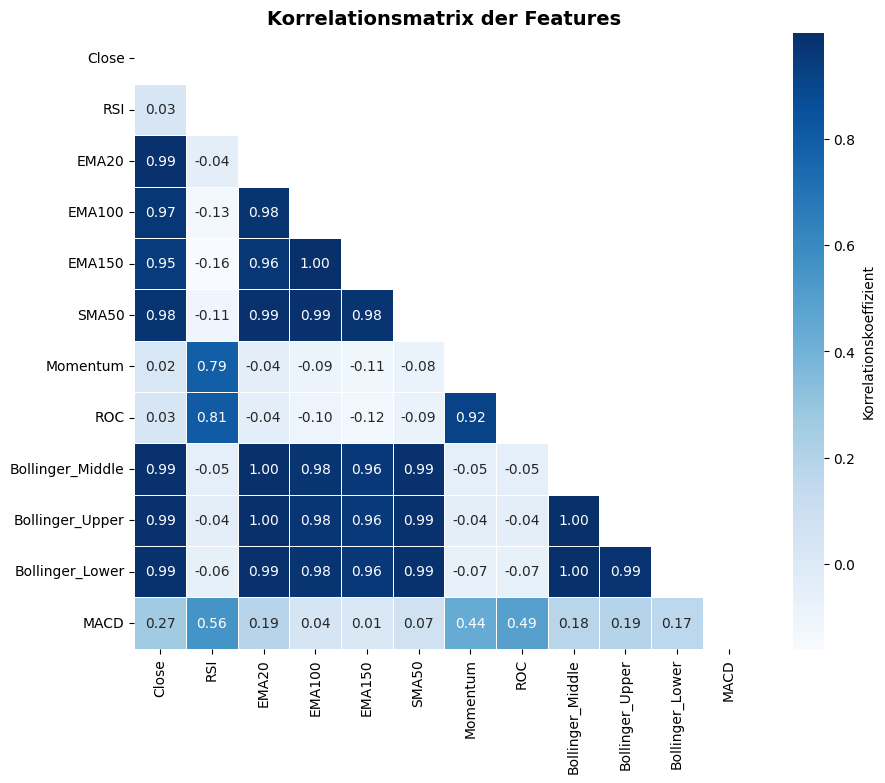

In [8]:
# Berechnen der Korrelationsmatrix
corr = data[['Close', 'RSI', 'EMA20', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Middle', 'Bollinger_Upper', 'Bollinger_Lower', 'MACD']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='Blues', mask=mask, cbar_kws={'label': 'Korrelationskoeffizient'},
            linewidths=0.5, linecolor='white')
plt.title('Korrelationsmatrix der Features', fontsize=14, fontweight='bold')
plt.show()

Feature Auswahl für das Modell
Aufgrund der hohen Korrelation und der Multikollinearität macht es Sinn, redundante Features zu eliminieren und nur repräsentative Features zu behalten. Hier ist eine mögliche Auswahl:

EMA20 oder SMA50: Behalte nur eines dieser Features, da beide stark miteinander und mit dem Ziel korrelieren. Zum Beispiel: EMA20.
Bollinger_Middle: Da es stark korreliert ist und repräsentativ für die Bollinger-Bänder ist, könnte man Bollinger_Middle anstelle von Upper und Lower behalten.
MACD: Trotz der negativen Korrelation kann MACD hilfreich sein, da es eine andere Dimension der Preisbewegung darstellt.
RSI: Obwohl die Korrelation gering ist, bietet RSI ein anderes Signal, das das Modell möglicherweise ergänzt.

In [9]:
data.drop(['Date','High', 'Low', 'Adj Close', 'Volume','Open', 'EMA100', 'EMA150', 'SMA50', 'Momentum', 'ROC', 'Bollinger_Upper', 'Bollinger_Lower'], axis=1, inplace=True)
data['Previous_Close'] = data['Close'].shift(1)
data.dropna(inplace=True)

In [11]:
import mlflow
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

# Zielvariablen für die Vorhersage erstellen
data['Target'] = (data['Close'] <= data['Previous_Close']).astype(int)

data_clean = data
data_clean.dropna(inplace=True)
data_clean.reset_index(drop=True, inplace=True)

# Auswahl und Skalierung der relevanten Features
selected_features = ['Close', 'RSI', 'EMA20', 'Bollinger_Middle', 'MACD', 'Previous_Close']
sc = MinMaxScaler(feature_range=(0, 1))
scaled_features = sc.fit_transform(data[selected_features])

def create_sequences(features, target, seq_length):
    sequences = []
    labels = []
    for i in range(len(features) - seq_length):
        sequence = features[i:i + seq_length]
        label = target[i + seq_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Hyperparameter-Definition für den ersten Versuch
lr = 0.001
SEQ_LENGTH = 30
EPOCHS = 30
BATCH_SIZE = 32

# Setzen des MLflow Tracking URI und Anlegen eines neuen Experiments
mlflow.set_tracking_uri("http://127.0.0.1:8080")
mlflow.set_experiment("Bitcoin Price Movement Prediction LSTM v2")

with mlflow.start_run():
    params = {
        "learning_rate": lr,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "seq_length": SEQ_LENGTH
    }
    mlflow.log_params(params)

    # Daten vorbereiten basierend auf der aktuellen seq_length
    X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)

    # Datenaufteilung: 70% Training, 20% Validierung, 10% Test
    train_size = int(0.7 * len(X))
    val_size = int(0.2 * len(X))
    test_size = len(X) - train_size - val_size

    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

    # Überprüfen der Formen der Daten
    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"X_test shape: {X_test.shape}")

    # Umformung der Daten für LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

    # Überprüfen der Formen der Daten nach Umformung
    print(f"Reshaped X_train shape: {X_train.shape}")
    print(f"Reshaped X_val shape: {X_val.shape}")
    print(f"Reshaped X_test shape: {X_test.shape}")

    optimizer = Adam(learning_rate=lr)

    # Modellarchitektur definieren
    model = Sequential()
    # Hinzufügen von LSTM-Schichten
    model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, len(selected_features))))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Modell trainieren
    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val))

    # Modell bewerten
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

    # MLflow-Logging
    mlflow.log_metric("loss", loss)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.keras.log_model(model, "model")

    # Vorhersagen treffen und Wahrscheinlichkeiten in binäre Werte umwandeln
    predictions = (model.predict(X_test) > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    print('Confusion Matrix')
    print(cm)

    # Classification Report
    cr = classification_report(y_test, predictions)
    print('Classification Report')
    print(cr)

    # Log confusion matrix and classification report
    with open("confusion_matrix_lstm.txt", "w") as f:
        f.write(str(cm))
    mlflow.log_artifact("confusion_matrix_lstm.txt")

    with open("classification_report_lstm.txt", "w") as f:
        f.write(cr)
    mlflow.log_artifact("classification_report_lstm.txt")

    # Set a tag for the run
    mlflow.set_tag("model", "LSTM")


X_train shape: (2426, 30, 6)
X_val shape: (693, 30, 6)
X_test shape: (348, 30, 6)
Reshaped X_train shape: (2426, 30, 6)
Reshaped X_val shape: (693, 30, 6)
Reshaped X_test shape: (348, 30, 6)
Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5252 - loss: 0.6909 - val_accuracy: 0.4877 - val_loss: 0.6955
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5357 - loss: 0.6899 - val_accuracy: 0.4877 - val_loss: 0.6981
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5408 - loss: 0.6889 - val_accuracy: 0.4848 - val_loss: 0.6949
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5458 - loss: 0.6872 - val_accuracy: 0.4848 - val_loss: 0.6934
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5257 - loss: 0.6904 - val_accuracy: 0.4921 - val_loss: 0.6958
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5398 - loss: 0.6902 - val_accuracy: 0.4935 - val_loss: 0.6945
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5639 - loss: 0.6827 - val_accuracy: 0.4935 - val_loss: 0.6938
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5386 - loss: 0.6884 - val_accuracy: 0.4877 - val_loss: 0.6943
Ep

2024/06/08 19:15:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6935608983039856
Test Accuracy: 0.4913793206214905
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step

c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[118  61]
 [116  53]]
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.66      0.57       179
           1       0.46      0.31      0.37       169

    accuracy                           0.49       348
   macro avg       0.48      0.49      0.47       348
weighted avg       0.49      0.49      0.48       348



In [12]:
import itertools
# Hyperparameter-Definition
learning_rates = [0.1, 0.05, 0.01, 0.001]
seq_lengths = [10,20, 30, 40, 50, 60]

# Alle Kombinationen der Hyperparameter erzeugen
combinations = list(itertools.product(learning_rates, seq_lengths))

In [13]:
for lr, SEQ_LENGTH in combinations:
    with mlflow.start_run():
        params = {
            "learning_rate": lr,
            "epochs": 30,
            "batch_size": 32,
            "seq_length": SEQ_LENGTH
        }
        mlflow.log_params(params)

        # Daten vorbereiten basierend auf der aktuellen seq_length
        X, y = create_sequences(scaled_features, data['Target'].values, SEQ_LENGTH)

        # Datenaufteilung: 70% Training, 20% Validierung, 10% Test
        train_size = int(0.7 * len(X))
        val_size = int(0.2 * len(X))
        test_size = len(X) - train_size - val_size

        X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

        # Reshape für LSTM
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
        X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

        optimizer = Adam(learning_rate=lr)

        # Modellarchitektur definieren
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', input_shape=(SEQ_LENGTH, len(selected_features)), return_sequences=True))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

        # Modell trainieren
        history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

        # Modell bewerten
        loss, accuracy = model.evaluate(X_test, y_test)
        print(f'Test Loss: {loss}')
        print(f'Test Accuracy: {accuracy}')

        # MLflow-Logging
        mlflow.log_metric("loss", loss)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.keras.log_model(model, "model")

        # Vorhersagen treffen und Wahrscheinlichkeiten in binäre Werte umwandeln
        predictions = (model.predict(X_test) > 0.5).astype(int)

        # Confusion Matrix
        cm = confusion_matrix(y_test, predictions)
        print('Confusion Matrix')
        print(cm)

        # Classification Report
        cr = classification_report(y_test, predictions)
        print('Classification Report')
        print(cr)

        # Log confusion matrix and classification report
        with open("confusion_matrix_lstm.txt", "w") as f:
            f.write(str(cm))
        mlflow.log_artifact("confusion_matrix_lstm.txt")

        with open("classification_report_lstm.txt", "w") as f:
            f.write(cr)
        mlflow.log_artifact("classification_report_lstm.txt")

        # Set a tag for the run
        mlflow.set_tag("model", "LSTM")

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5038 - loss: 2.5962 - val_accuracy: 0.4864 - val_loss: 0.7026
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5486 - loss: 0.6905 - val_accuracy: 0.4864 - val_loss: 0.7125
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5502 - loss: 0.6915 - val_accuracy: 0.4864 - val_loss: 0.6971
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5579 - loss: 0.6884 - val_accuracy: 0.4864 - val_loss: 0.6945
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5448 - loss: 0.6934 - val_accuracy: 0.4864 - val_loss: 0.6965
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5213 - loss: 0.6925 - val_accuracy: 0.4864 - val_loss: 0.6992
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5257 - loss: 0.6917 - val_accuracy: 0.4864 - val_loss: 0.6995
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5219 - loss: 0.6923 - val_accuracy: 0.4864 - val_loss: 0.7030
Epo

2024/06/08 19:20:31 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6927262544631958
Test Accuracy: 0.5171428322792053
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Confusion Matrix
[[181   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       181
           1       0.00      0.00      0.00       169

    accuracy                           0.52       350
   macro avg       0.26      0.50      0.34       350
weighted avg       0.27      0.52      0.35       350

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5190 - loss: 1041349.1250 - val_accuracy: 0.4863 - val_loss: 0.7081
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5548 - loss: 0.6902 - val_accuracy: 0.5137 - val_loss: 0.7135
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5255 - loss: 0.7113 - val_accuracy: 0.4863 - val_loss: 0.7069
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5267 - loss: 0.7077 - val_accuracy: 0.4863 - val_loss: 0.7031
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5167 - loss: 0.6998 - val_accuracy: 0.4863 - val_loss: 0.7225
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5609 - loss: 0.6903 - val_accuracy: 0.4863 - val_loss: 0.7274
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5358 - loss: 0.6980 - val_accuracy: 0.4863 - val_loss: 0.6942
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5389 - loss: 0.6959 - val_accuracy: 0.4863 - val_loss: 0.7

2024/06/08 19:20:52 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6941537261009216
Test Accuracy: 0.49283668398857117
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Confusion Matrix
[[ 24 156]
 [ 21 148]]
Classification Report
              precision    recall  f1-score   support

           0       0.53      0.13      0.21       180
           1       0.49      0.88      0.63       169

    accuracy                           0.49       349
   macro avg       0.51      0.50      0.42       349
weighted avg       0.51      0.49      0.41       349

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.4842 - loss: 178014848.0000 - val_accuracy: 0.4877 - val_loss: 0.7067
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5210 - loss: 0.7076 - val_accuracy: 0.4877 - val_loss: 0.7667
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4899 - loss: 7.9975 - val_accuracy: 0.4935 - val_loss: 1.1032
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5296 - loss: 0.7201 - val_accuracy: 0.4863 - val_loss: 0.6996
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5506 - loss: 0.6887 - val_accuracy: 0.5051 - val_loss: 0.6955
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5456 - loss: 0.6908 - val_accuracy: 0.5180 - val_loss: 0.6937
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5466 - loss: 0.6925 - val_accuracy: 0.4877 - val_loss: 0.6998
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5598 - loss: 0.6880 - val_accuracy: 0.4921 - val_loss: 0

2024/06/08 19:21:18 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6934344172477722
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5125 - loss: 3172451.2500 - val_accuracy: 0.4964 - val_loss: 94.0152
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5127 - loss: nan - val_accuracy: 0.4877 - val_loss: nan
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5496 - loss: nan - val_accuracy: 0.4877 - val_loss: nan
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5399 - loss: nan - val_accuracy: 0.4877 - val_loss: nan
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5538 - loss: nan - val_accuracy: 0.4877 - val_loss: nan
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5525 - loss: nan - val_accuracy: 0.4877 - val_loss: nan
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5532 - loss: nan - val_accuracy: 0.4877 - val_loss: nan
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5596 - loss: nan - val_accuracy: 0.4877 - val_loss: nan
Epoch 9/30
76/76 ━━━━━━━━━━━━━

2024/06/08 19:21:56 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: nan
Test Accuracy: 0.5129683017730713
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix
[[178   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       178
           1       0.00      0.00      0.00       169

    accuracy                           0.51       347
   macro avg       0.26      0.50      0.34       347
weighted avg       0.26      0.51      0.35       347

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5375 - loss: 14833071161344.0000 - val_accuracy: 0.5080 - val_loss: 126.7154
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4950 - loss: 3210448384.0000 - val_accuracy: 0.4891 - val_loss: 1907.1923
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5242 - loss: 4310.0161 - val_accuracy: 0.4891 - val_loss: 13661.3740
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5101 - loss: 16129.0156 - val_accuracy: 0.4891 - val_loss: 222.7248
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5269 - loss: 103.8622 - val_accuracy: 0.4891 - val_loss: 223.3480
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5356 - loss: 80.6551 - val_accuracy: 0.4891 - val_loss: 248.0717
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5033 - loss: 103.9088 - val_accuracy: 0.4891 - val_loss: 239.6141
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5263 -

2024/06/08 19:22:38 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 282.7819519042969
Test Accuracy: 0.5115606784820557
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix
[[177   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       177
           1       0.00      0.00      0.00       169

    accuracy                           0.51       346
   macro avg       0.26      0.50      0.34       346
weighted avg       0.26      0.51      0.35       346

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5439 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5379 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5323 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5495 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5495 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5467 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5494 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5588 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 9/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19

2024/06/08 19:23:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: nan
Test Accuracy: 0.5130434632301331
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix
[[177   0]
 [168   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       177
           1       0.00      0.00      0.00       168

    accuracy                           0.51       345
   macro avg       0.26      0.50      0.34       345
weighted avg       0.26      0.51      0.35       345

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5382 - loss: 2.5775 - val_accuracy: 0.4864 - val_loss: 0.6947
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5639 - loss: 0.6875 - val_accuracy: 0.4864 - val_loss: 0.6944
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5331 - loss: 0.6912 - val_accuracy: 0.4864 - val_loss: 0.7029
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5577 - loss: 0.6876 - val_accuracy: 0.4864 - val_loss: 0.6968
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5564 - loss: 0.6887 - val_accuracy: 0.4864 - val_loss: 0.6978
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5401 - loss: 0.6905 - val_accuracy: 0.4864 - val_loss: 0.6950
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5275 - loss: 0.6911 - val_accuracy: 0.4864 - val_loss: 0.6944
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5469 - loss: 0.6895 - val_accuracy: 0.4864 - val_loss: 0.6952
Epo

2024/06/08 19:23:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6935632824897766
Test Accuracy: 0.5171428322792053
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix
[[181   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       181
           1       0.00      0.00      0.00       169

    accuracy                           0.52       350
   macro avg       0.26      0.50      0.34       350
weighted avg       0.27      0.52      0.35       350

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5343 - loss: 2.4980 - val_accuracy: 0.4863 - val_loss: 0.7139
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5522 - loss: 0.6913 - val_accuracy: 0.5137 - val_loss: 0.6930
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4831 - loss: 0.6940 - val_accuracy: 0.4863 - val_loss: 0.7084
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5129 - loss: 0.6979 - val_accuracy: 0.4863 - val_loss: 0.7079
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5411 - loss: 0.6907 - val_accuracy: 0.4863 - val_loss: 0.6992
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5486 - loss: 0.6904 - val_accuracy: 0.4863 - val_loss: 0.7076
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5450 - loss: 0.6913 - val_accuracy: 0.4863 - val_loss: 0.6974
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5507 - loss: 0.6898 - val_accuracy: 0.4863 - val_loss: 0.6940
Ep

2024/06/08 19:24:03 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6989243030548096
Test Accuracy: 0.515759289264679
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix
[[180   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       180
           1       0.00      0.00      0.00       169

    accuracy                           0.52       349
   macro avg       0.26      0.50      0.34       349
weighted avg       0.27      0.52      0.35       349

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5380 - loss: 27051.1738 - val_accuracy: 0.4877 - val_loss: 0.7040
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5278 - loss: 0.6953 - val_accuracy: 0.4921 - val_loss: 0.6950
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5485 - loss: 0.6886 - val_accuracy: 0.4877 - val_loss: 0.6962
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5302 - loss: 0.6917 - val_accuracy: 0.4877 - val_loss: 0.7092
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5391 - loss: 0.6929 - val_accuracy: 0.4906 - val_loss: 0.6944
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5534 - loss: 0.6884 - val_accuracy: 0.4993 - val_loss: 0.6935
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5678 - loss: 0.6861 - val_accuracy: 0.5094 - val_loss: 0.6934
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5449 - loss: 3224177.7500 - val_accuracy: 0.5152 - val_loss:

2024/06/08 19:24:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6956639885902405
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5073 - loss: 4680.7632 - val_accuracy: 0.4877 - val_loss: 0.6987
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5044 - loss: 0.6941 - val_accuracy: 0.4877 - val_loss: 0.7006
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5421 - loss: 0.6904 - val_accuracy: 0.4877 - val_loss: 0.6966
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5570 - loss: 0.6878 - val_accuracy: 0.4906 - val_loss: 0.6937
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5535 - loss: 0.6891 - val_accuracy: 0.4877 - val_loss: 0.6966
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5343 - loss: 0.6915 - val_accuracy: 0.4877 - val_loss: 0.6991
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5241 - loss: 0.6939 - val_accuracy: 0.4877 - val_loss: 0.7081
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5543 - loss: 0.6878 - val_accuracy: 0.4863 - val_loss:

2024/06/08 19:25:02 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.696225106716156
Test Accuracy: 0.5129683017730713
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix
[[178   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       178
           1       0.00      0.00      0.00       169

    accuracy                           0.51       347
   macro avg       0.26      0.50      0.34       347
weighted avg       0.26      0.51      0.35       347

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.4943 - loss: 2233567677513728.0000 - val_accuracy: 0.4935 - val_loss: 1.3323
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5101 - loss: 985990656.0000 - val_accuracy: 0.5196 - val_loss: 1205113.2500
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5112 - loss: 95379560.0000 - val_accuracy: 0.4891 - val_loss: 0.7636
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4891 - loss: 0.7103 - val_accuracy: 0.4891 - val_loss: 0.7612
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5576 - loss: 0.6953 - val_accuracy: 0.4891 - val_loss: 0.7569
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5472 - loss: 0.6964 - val_accuracy: 0.4891 - val_loss: 0.7425
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5468 - loss: 0.6952 - val_accuracy: 0.4891 - val_loss: 0.7488
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5269 - loss: 0.6995 -

2024/06/08 19:25:42 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6966743469238281
Test Accuracy: 0.5115606784820557
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix
[[177   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       177
           1       0.00      0.00      0.00       169

    accuracy                           0.51       346
   macro avg       0.26      0.50      0.34       346
weighted avg       0.26      0.51      0.35       346

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5367 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5505 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5396 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5399 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5568 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5269 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5459 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5375 - loss: nan - val_accuracy: 0.4876 - val_loss: nan
Epoch 9/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 20

2024/06/08 19:26:32 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: nan
Test Accuracy: 0.5130434632301331
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Confusion Matrix
[[177   0]
 [168   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       177
           1       0.00      0.00      0.00       168

    accuracy                           0.51       345
   macro avg       0.26      0.50      0.34       345
weighted avg       0.26      0.51      0.35       345

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5313 - loss: 0.6917 - val_accuracy: 0.4864 - val_loss: 0.6952
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5489 - loss: 0.6900 - val_accuracy: 0.4892 - val_loss: 0.6951
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5533 - loss: 0.6876 - val_accuracy: 0.4950 - val_loss: 0.6948
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5480 - loss: 0.6886 - val_accuracy: 0.4864 - val_loss: 0.6972
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5479 - loss: 0.6885 - val_accuracy: 0.4864 - val_loss: 0.6963
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5497 - loss: 0.6873 - val_accuracy: 0.4907 - val_loss: 0.6933
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5534 - loss: 0.6898 - val_accuracy: 0.4864 - val_loss: 0.6961
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5512 - loss: 0.6894 - val_accuracy: 0.4864 - val_loss: 0.6985
Epo

2024/06/08 19:26:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928225159645081
Test Accuracy: 0.5171428322792053
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[181   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       181
           1       0.00      0.00      0.00       169

    accuracy                           0.52       350
   macro avg       0.26      0.50      0.34       350
weighted avg       0.27      0.52      0.35       350

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5269 - loss: 0.6948 - val_accuracy: 0.4863 - val_loss: 0.7025
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5535 - loss: 0.6873 - val_accuracy: 0.4863 - val_loss: 0.6969
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5526 - loss: 0.6890 - val_accuracy: 0.4863 - val_loss: 0.6975
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5448 - loss: 0.6892 - val_accuracy: 0.4863 - val_loss: 0.6994
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5464 - loss: 0.6891 - val_accuracy: 0.4863 - val_loss: 0.6972
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5643 - loss: 0.6885 - val_accuracy: 0.4863 - val_loss: 0.6976
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5448 - loss: 0.6887 - val_accuracy: 0.4863 - val_loss: 0.6992
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5614 - loss: 0.6842 - val_accuracy: 0.4863 - val_loss: 0.6958
Ep

2024/06/08 19:27:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6930904984474182
Test Accuracy: 0.515759289264679
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix
[[180   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       180
           1       0.00      0.00      0.00       169

    accuracy                           0.52       349
   macro avg       0.26      0.50      0.34       349
weighted avg       0.27      0.52      0.35       349

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5312 - loss: 0.6947 - val_accuracy: 0.4877 - val_loss: 0.6962
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5374 - loss: 0.6901 - val_accuracy: 0.4877 - val_loss: 0.6989
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5582 - loss: 0.6871 - val_accuracy: 0.4921 - val_loss: 0.6945
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5333 - loss: 0.6909 - val_accuracy: 0.4877 - val_loss: 0.6966
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5633 - loss: 0.6865 - val_accuracy: 0.4877 - val_loss: 0.6968
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5382 - loss: 0.6900 - val_accuracy: 0.4877 - val_loss: 0.6993
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5376 - loss: 0.6909 - val_accuracy: 0.4877 - val_loss: 0.7011
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5359 - loss: 0.6917 - val_accuracy: 0.4877 - val_loss: 0.6997
Ep

2024/06/08 19:27:36 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6937212347984314
Test Accuracy: 0.5143678188323975
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Confusion Matrix
[[179   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       179
           1       0.00      0.00      0.00       169

    accuracy                           0.51       348
   macro avg       0.26      0.50      0.34       348
weighted avg       0.26      0.51      0.35       348

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5548 - loss: 0.6891 - val_accuracy: 0.4877 - val_loss: 0.6960
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5411 - loss: 0.6901 - val_accuracy: 0.4877 - val_loss: 0.6955
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5385 - loss: 0.6901 - val_accuracy: 0.4877 - val_loss: 0.6982
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5455 - loss: 0.6906 - val_accuracy: 0.4877 - val_loss: 0.6994
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5204 - loss: 0.6951 - val_accuracy: 0.4877 - val_loss: 0.7014
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5503 - loss: 0.6875 - val_accuracy: 0.4877 - val_loss: 0.6954
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5439 - loss: 0.6882 - val_accuracy: 0.4877 - val_loss: 0.6947
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5377 - loss: 0.6907 - val_accuracy: 0.4877 - val_loss: 0.

2024/06/08 19:28:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928761005401611
Test Accuracy: 0.5129683017730713
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Confusion Matrix
[[178   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       178
           1       0.00      0.00      0.00       169

    accuracy                           0.51       347
   macro avg       0.26      0.50      0.34       347
weighted avg       0.26      0.51      0.35       347

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5504 - loss: 0.6971 - val_accuracy: 0.4891 - val_loss: 0.6987
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5534 - loss: 0.6872 - val_accuracy: 0.4891 - val_loss: 0.6960
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5505 - loss: 0.6898 - val_accuracy: 0.4891 - val_loss: 0.6985
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5434 - loss: 0.6896 - val_accuracy: 0.4891 - val_loss: 0.6980
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5425 - loss: 0.6897 - val_accuracy: 0.4891 - val_loss: 0.6993
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5308 - loss: 0.6916 - val_accuracy: 0.4891 - val_loss: 0.6978
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5407 - loss: 0.6894 - val_accuracy: 0.4891 - val_loss: 0.6964
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5345 - loss: 0.6902 - val_accuracy: 0.4891 - val_loss: 0.

2024/06/08 19:28:50 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6930949687957764
Test Accuracy: 0.5115606784820557
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[177   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      1.00      0.68       177
           1       0.00      0.00      0.00       169

    accuracy                           0.51       346
   macro avg       0.26      0.50      0.34       346
weighted avg       0.26      0.51      0.35       346

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5469 - loss: 0.6915 - val_accuracy: 0.4876 - val_loss: 0.6995
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5457 - loss: 0.6893 - val_accuracy: 0.4876 - val_loss: 0.6971
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5661 - loss: 0.6846 - val_accuracy: 0.4876 - val_loss: 0.6963
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5381 - loss: 0.6897 - val_accuracy: 0.4876 - val_loss: 0.7001
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5468 - loss: 0.6898 - val_accuracy: 0.4876 - val_loss: 0.6985
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5489 - loss: 0.6881 - val_accuracy: 0.4876 - val_loss: 0.6982
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5498 - loss: 0.6884 - val_accuracy: 0.4876 - val_loss: 0.6966
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5526 - loss: 0.6867 - val_accuracy: 0.4876 - val_loss: 0.

2024/06/08 19:29:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6968895792961121
Test Accuracy: 0.4724637567996979
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[ 95  82]
 [100  68]]
Classification Report
              precision    recall  f1-score   support

           0       0.49      0.54      0.51       177
           1       0.45      0.40      0.43       168

    accuracy                           0.47       345
   macro avg       0.47      0.47      0.47       345
weighted avg       0.47      0.47      0.47       345

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5121 - loss: 0.6924 - val_accuracy: 0.4864 - val_loss: 0.6993
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5500 - loss: 0.6879 - val_accuracy: 0.4878 - val_loss: 0.6950
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5329 - loss: 0.6911 - val_accuracy: 0.4835 - val_loss: 0.6946
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5531 - loss: 0.6870 - val_accuracy: 0.4778 - val_loss: 0.6945
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5553 - loss: 0.6859 - val_accuracy: 0.4749 - val_loss: 0.6938
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5417 - loss: 0.6890 - val_accuracy: 0.4735 - val_loss: 0.6943
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5268 - loss: 0.6907 - val_accuracy: 0.4792 - val_loss: 0.6950
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5450 - loss: 0.6869 - val_accuracy: 0.4950 - val_loss: 0.6948
Epo

2024/06/08 19:29:41 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928772330284119
Test Accuracy: 0.5199999809265137
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Confusion Matrix
[[155  26]
 [142  27]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.86      0.65       181
           1       0.51      0.16      0.24       169

    accuracy                           0.52       350
   macro avg       0.52      0.51      0.45       350
weighted avg       0.52      0.52      0.45       350

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5345 - loss: 0.6913 - val_accuracy: 0.4863 - val_loss: 0.6992
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5594 - loss: 0.6852 - val_accuracy: 0.4863 - val_loss: 0.6954
Epoch 3/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5687 - loss: 0.6864 - val_accuracy: 0.4950 - val_loss: 0.6938
Epoch 4/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5632 - loss: 0.6854 - val_accuracy: 0.4863 - val_loss: 0.6948
Epoch 5/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5321 - loss: 0.6895 - val_accuracy: 0.4863 - val_loss: 0.6946
Epoch 6/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5627 - loss: 0.6857 - val_accuracy: 0.4863 - val_loss: 0.6946
Epoch 7/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5453 - loss: 0.6891 - val_accuracy: 0.4863 - val_loss: 0.6957
Epoch 8/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5446 - loss: 0.6903 - val_accuracy: 0.4863 - val_loss: 0.6959
Epo

2024/06/08 19:29:59 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6928585171699524
Test Accuracy: 0.515759289264679
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Confusion Matrix
[[180   0]
 [169   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       180
           1       0.00      0.00      0.00       169

    accuracy                           0.52       349
   macro avg       0.26      0.50      0.34       349
weighted avg       0.27      0.52      0.35       349

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5291 - loss: 0.6908 - val_accuracy: 0.4877 - val_loss: 0.6944
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5536 - loss: 0.6867 - val_accuracy: 0.4877 - val_loss: 0.6955
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5420 - loss: 0.6878 - val_accuracy: 0.4892 - val_loss: 0.6944
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5359 - loss: 0.6891 - val_accuracy: 0.4921 - val_loss: 0.6962
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5477 - loss: 0.6866 - val_accuracy: 0.4863 - val_loss: 0.6956
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5346 - loss: 0.6884 - val_accuracy: 0.4978 - val_loss: 0.6949
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5376 - loss: 0.6889 - val_accuracy: 0.4949 - val_loss: 0.6951
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5459 - loss: 0.6855 - val_accuracy: 0.4877 - val_loss: 0.6945
Ep

2024/06/08 19:30:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6930137872695923
Test Accuracy: 0.522988498210907
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix
[[153  26]
 [140  29]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.85      0.65       179
           1       0.53      0.17      0.26       169

    accuracy                           0.52       348
   macro avg       0.52      0.51      0.45       348
weighted avg       0.52      0.52      0.46       348

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5478 - loss: 0.6901 - val_accuracy: 0.4877 - val_loss: 0.6969
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5516 - loss: 0.6874 - val_accuracy: 0.4877 - val_loss: 0.6946
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5408 - loss: 0.6899 - val_accuracy: 0.4949 - val_loss: 0.6940
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5411 - loss: 0.6893 - val_accuracy: 0.4848 - val_loss: 0.6958
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5463 - loss: 0.6845 - val_accuracy: 0.4906 - val_loss: 0.6950
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5360 - loss: 0.6896 - val_accuracy: 0.4848 - val_loss: 0.6941
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5442 - loss: 0.6871 - val_accuracy: 0.4891 - val_loss: 0.6939
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5667 - loss: 0.6853 - val_accuracy: 0.4732 - val_loss: 0.

2024/06/08 19:30:48 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6935052871704102
Test Accuracy: 0.49567723274230957
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Confusion Matrix
[[138  40]
 [135  34]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.78      0.61       178
           1       0.46      0.20      0.28       169

    accuracy                           0.50       347
   macro avg       0.48      0.49      0.45       347
weighted avg       0.48      0.50      0.45       347

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5441 - loss: 0.6911 - val_accuracy: 0.4906 - val_loss: 0.6958
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5463 - loss: 0.6871 - val_accuracy: 0.4731 - val_loss: 0.6941
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5538 - loss: 0.6858 - val_accuracy: 0.4848 - val_loss: 0.6934
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5541 - loss: 0.6862 - val_accuracy: 0.4891 - val_loss: 0.6935
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5409 - loss: 0.6891 - val_accuracy: 0.4891 - val_loss: 0.6957
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5404 - loss: 0.6883 - val_accuracy: 0.4891 - val_loss: 0.6956
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5388 - loss: 0.6894 - val_accuracy: 0.4935 - val_loss: 0.6950
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5452 - loss: 0.6879 - val_accuracy: 0.4862 - val_loss: 0.

2024/06/08 19:31:25 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6935074925422668
Test Accuracy: 0.5144508481025696
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Confusion Matrix
[[147  30]
 [138  31]]
Classification Report
              precision    recall  f1-score   support

           0       0.52      0.83      0.64       177
           1       0.51      0.18      0.27       169

    accuracy                           0.51       346
   macro avg       0.51      0.51      0.45       346
weighted avg       0.51      0.51      0.46       346

Epoch 1/30


c:\WWI2021\Semester 6\Machine Learning Project\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.5493 - loss: 0.6902 - val_accuracy: 0.4876 - val_loss: 0.6960
Epoch 2/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5496 - loss: 0.6870 - val_accuracy: 0.4745 - val_loss: 0.6949
Epoch 3/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5504 - loss: 0.6872 - val_accuracy: 0.4876 - val_loss: 0.6949
Epoch 4/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5367 - loss: 0.6884 - val_accuracy: 0.4993 - val_loss: 0.6941
Epoch 5/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5562 - loss: 0.6867 - val_accuracy: 0.4949 - val_loss: 0.6947
Epoch 6/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5450 - loss: 0.6870 - val_accuracy: 0.4949 - val_loss: 0.6950
Epoch 7/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5413 - loss: 0.6856 - val_accuracy: 0.4905 - val_loss: 0.6951
Epoch 8/30
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5375 - loss: 0.6895 - val_accuracy: 0.4891 - val_loss: 0.

2024/06/08 19:32:08 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.


Test Loss: 0.6932436227798462
Test Accuracy: 0.5101449489593506
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix
[[145  32]
 [137  31]]
Classification Report
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       177
           1       0.49      0.18      0.27       168

    accuracy                           0.51       345
   macro avg       0.50      0.50      0.45       345
weighted avg       0.50      0.51      0.45       345



Hyperparameter-Definition und Modelltraining

In [ ]:
# Vorhersagen treffen
predictions = (model.predict(X_test) > 0.5).astype(int)

# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')



In [ ]:
# Modell bewerten
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# MLflow-Logging
mlflow.log_metric("loss", loss)
mlflow.log_metric("accuracy", accuracy)
mlflow.keras.log_model(model, "model")


In [ ]:
# Ergebnisse visualisieren
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cm)

# Classification Report
cr = classification_report(y_test, predictions)
print('Classification Report')
print(cr)

# Plot der Ergebnisse
plt.figure(figsize=(14, 5))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', marker='o')
plt.scatter(range(len(predictions)), predictions, color='red', label='Predicted', marker='x')
plt.title('Bitcoin Price Movement Prediction')
plt.xlabel('Time')
plt.ylabel('Class')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = model.predict(X_test).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_prob = model.predict(X_test).ravel()
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = average_precision_score(y_test, y_pred_prob)

plt.figure()
plt.step(recall, precision, where='post', label='Average precision score: AP={0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [ ]:
y_pred_prob = model.predict(X_test).ravel()

plt.figure(figsize=(10, 5))
plt.hist(y_pred_prob, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()


Optimierungsmöglichkeiten für wenn Lifecycle Management Tool eingeführt ist:

Wenn Sie die Preisbewegung (zum Beispiel die Richtung der Preisänderung oder die prozentuale Änderung) anstelle des tatsächlichen Preises vorhersagen und feststellen, dass die Leistung des Modells nicht zufriedenstellend ist, gibt es mehrere Ansätze, um die Vorhersagequalität zu verbessern. Hier sind einige Strategien, die Sie in Betracht ziehen können:


### 2. **Modellarchitektur anpassen**
- **Anzahl der LSTM-Einheiten ändern**: Erhöhen oder verringern Sie die Anzahl der Neuronen in den LSTM-Schichten, um zu sehen, ob dies die Modellleistung beeinflusst.
- **Tiefe des Netzwerks**: Fügen Sie mehrere LSTM-Schichten hinzu, um ein tieferes Netzwerk zu erstellen, das möglicherweise komplexere Muster erfassen kann.
- **Dropout hinzufügen**: Um Overfitting zu vermeiden, fügen Sie Dropout-Schichten hinzu, die helfen können, die Generalisierbarkeit des Modells zu verbessern.

### 3. **Hyperparameter optimieren**
- **Lernrate anpassen**: Experimentieren Sie mit unterschiedlichen Lernraten und anderen Optimierungsparametern.
- **Batch-Größe und Epochenzahl**: Das Ändern der Batch-Größe und der Anzahl der Epochen kann erhebliche Auswirkungen auf das Trainingsergebnis haben.
- **Regularisierung anwenden**: Experimentieren Sie mit verschiedenen Arten von Regularisierungen (L1, L2), um das Overfitting zu kontrollieren.

### 4. **Verlustfunktion anpassen**
- **Andere Verlustfunktionen ausprobieren**: Wenn Sie die Richtung der Preisbewegung vorhersagen, könnte eine binäre Kreuzentropie (wenn es sich um eine Klassifikationsaufgabe handelt) oder eine benutzerdefinierte Verlustfunktion, die speziell für Ihr Vorhersageziel entwickelt wurde, nützlich sein.

### 5. **Trainingstechniken überprüfen**
- **Frühzeitiges Beenden**: Verwenden Sie Early Stopping, um das Training zu beenden, wenn sich die Validierungsleistung nicht mehr verbessert.
- **Daten-Shuffling und -Partitionierung**: Stellen Sie sicher, dass Ihre Trainings-, Validierungs- und Testdatensätze richtig partitioniert und während des Trainings effektiv gemischt werden.

### 6. **Evaluation und Benchmarking**
- **Cross-Validation verwenden**: Statt einer einfachen Train-Test-Split kann Cross-Validation eine robustere Evaluation der Modellleistung bieten.
- **Leistungsmetriken**: Überprüfen Sie, ob Sie die richtigen Metriken für die Bewertung des Modells verwenden. Für Klassifikationsaufgaben sind Genauigkeit, F1-Score, ROC-AUC usw. relevant.

Diese Ansätze bieten verschiedene Wege, die Modellleistung zu verbessern und sollten je nach spezifischem Szenario und den Ergebnissen der initialen Modellbewertungen angepasst werden.